# Table of Contents:
* [1) SEP Regression Onset Tool (Introduction)](#1.-SEP-Regression-Onset-Tool)
* [2) Selecting the Data Source](#2.-Selecting-the-Data-Source)
* [3) Data Loading](#3.-Data-Loading)
* [4) Quicklook Plot](#4.-Quicklook-Plot)
* [5) Regression Analysis](#5.-Regression-Analysis)
    - [5.1 The Results of the Regression Analysis](#5.1-The-Results-of-the-Regression-Analysis)
* [6) Saving the Figure](#6.-Saving-the-Figure)
* [7) Advanced: Combining Energy Channels](#7.-Advanced:-Combining-Energy-Channels)

## 1. SEP Regression Onset Tool

This tool downloads SEP intensity time-series data and searches for an SEP event onset time and other possible breakpoints using a regression method.

The user therefore selects a time interval in which the method looks for breakpoints in the data (using the logarithm of the intensities). The user also controls the amount of breakpoints that are searched for in the data and the time-averaging that may be applied to it.

The Regression Onset Tool employs the `piecewise-regression` Python package [(Pilgrim, 2021)](https://doi.org/10.21105/joss.03859). The package works by an iterative algorithm that seeks to find the optimal placement for breakpoints such that the errors of the linear fits are minimized.

<img src="regression_onset/images/segmented_regression.png" alt="segmented regression" width="500px">
Figure 1. An illustration of segmented regression applied to data with 3 breakpoints (Pilgrim, 2021).

### Saving figures

You can usually save a figure from the Notebook by right-clicking on it while holding down the ⇧ Shift key, then select "Save Image As..." (or similar).

In [ ]:
import datetime as dt
import os
import pandas as pd
import regression_onset as reg
from regression_onset import select_data
from seppy.tools import Event
from seppy.util import jupyterhub_data_path

## 2. Selecting the Data Source
### Choose either SEPpy or User defined

- `SEPpy` employs automatic data-loading capabilities online
- `User defined` accesses data from your local directory

In [ ]:
display(select_data.data_file)

ToggleButtons(description='Data source: ', index=1, options=('SEPpy (online)', 'User defined'), tooltips=('Sel…

### Provide file name of your own file (if used), otherwise select time interval to load data

In [ ]:
# Set your local path where you want to save the data files
data_path = f"{os.getcwd()}{os.sep}data"

# The name of your data file, if you're loading in your own data. 
filename = "solo_ept_sun_e.csv"

# To download (or load if files are locally present) SEPpy data, one needs to provide a time span.
# If you're not using SEPpy, this can be ignored.
# The format is (year, month, day)
start_date = dt.datetime(2022, 1, 20)
end_date = dt.datetime(2022, 1, 21)

if select_data._seppy_selected(select_data.data_file):
    import seppy.tools.widgets as w
    display(w.spacecraft_drop, w.sensor_drop, w.view_drop, w.species_drop)

## 3. Data Loading
#### The next cell takes care of loading in the data. Just run it.

>If the source of the data is SEPpy, a table displaying the energy channels of the Instrument will be shown for the chosen particle species after the data has been loaded in.

>This cell also initializes the object that runs the analysis.

In [ ]:
if select_data._seppy_selected(select_data.data_file):
    # Initializes the SEPpy Event object
    seppy_data = Event(spacecraft=w.spacecraft_drop.value, sensor=w.sensor_drop.value, species=w.species_drop.value,
                         start_date=start_date, end_date=end_date, data_level="l2",
                         data_path=data_path, viewing=w.view_drop.value)

    # Exports the SEPpy data and metadata to pandas dataframes and a dictionary
    df = reg.externals.export_seppy_data(event=seppy_data)
    meta_df, meta_dict = reg.externals.parse_seppy_metadata(event=seppy_data)
    with pd.option_context("display.max_rows", None):
        display(meta_df)

else:
    # Uses pandas to_csv() to load in a local data file:
    df = pd.read_csv(f"{data_path}{os.sep}{filename}", parse_dates=True, index_col=0)
    meta_df, meta_dict = None, None


# Initialize the tool with input data
event = reg.Reg(data=df, data_source=select_data.data_file.value, meta_df=meta_df, meta_dict=meta_dict)

## 4. Quicklook Plot

#### Use the quicklook-plot in the cell below to select a time interval in which the regression method is applied to find breakpoints:
#### The plot produced by `quicklook()` is an **interactive** plot.

Select a time interval that encompasses at least the background and peak of the event. This is done to mark the segment of the data that the tool will be applied on. Possible options to do this are: 

1) Clicking on the plot. The first click marks the start of the selection, and the second click marks the end of the selection. This requires `selection = None`. To redo the selection, run the cell again.
2) Use the `selection` parameter to select a time interval. `selection` can be either a single timestamp or a pair of timestamps given as strings, e.g., ["2025-03-19 12:00", "2025-03-20 18:00"]. A pair of timestamps defines a selection between the timestamps; a single timestamp defines selection up to that time from the start of the data file.

Vertical green line(s) on the plot indicate the selection boundaries. A light green shading is also applied over the whole selection.

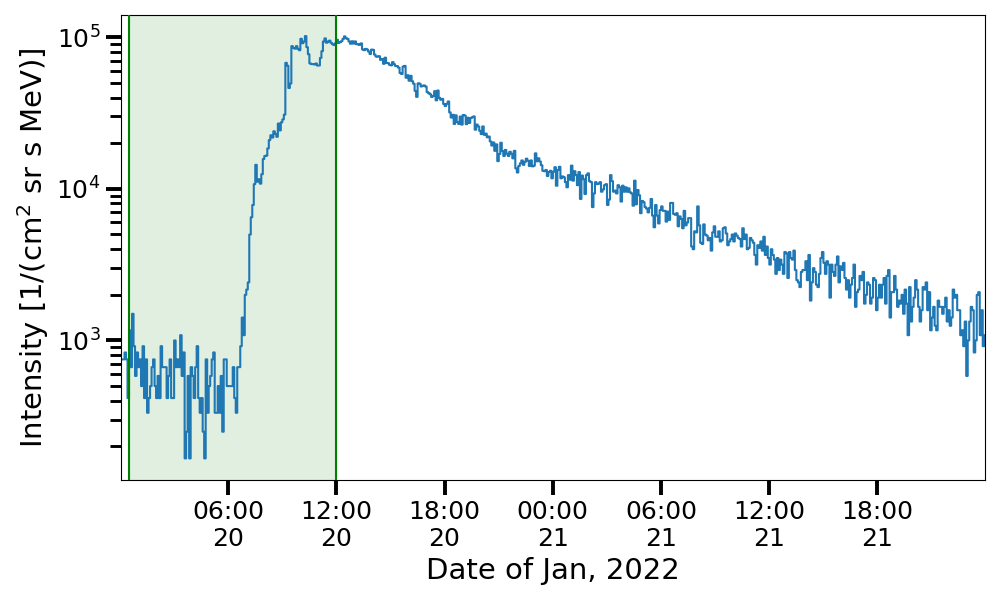

In [ ]:
# Choose the channel (column name, see display(df) above)
channel = "E4"

# See explanation above for details 
selection = ["2022-01-20 00:30", "2022-01-20 12:00"]
# selection = None

# Display a quicklook plot of the input data (df).
# Apply the selection of data for the tool by 'selection' parameter or by clicking
# on the plot.
# The line magic 'ipympl' enables interactive mode
%matplotlib ipympl
event.quicklook(channel=channel, resample="5min", selection=selection)

## 5. Regression Analysis
### The method performs linear regression based on the logarithm of the intensity time profiles  (find_breakpoints() -method). Choose a number of breakpoints and run the method. It is the task of the user to identify, which breakpoint marks the onset of the event. Iterations using different numbers of breakpoints are recommended.

> fill_zeroes (bool) is a switch that applies filling out 0 count bins with a filler value f that satisfies the equation:
$$
\mu_{lg} = \frac{1}{N} \bigg( \sum_{i}^{N_{nz}} \lg(j_{i,nz}) + (N-N_{nz}) \lg(f) \bigg),
$$
> where $\mu_{lg}$ is the logarithm of the mean of the background, $N$ is the total number of data points in the background, $N_{nz}$ is the number of non-zero data in the background, $j_{i, nz}$ is a non-zero intensity measurement in the background and $\lg(\cdot)$ is the 10-base logarithm.
> 
> Setting fill_zeroes = False means 0 counts get ignored altogether.

Data min: 2.61329384213705, max: 5.04067234369162
Data selection: 2022-01-20 00:30:00.451561, 2022-01-20 11:59:00.451561
Regression converged: True


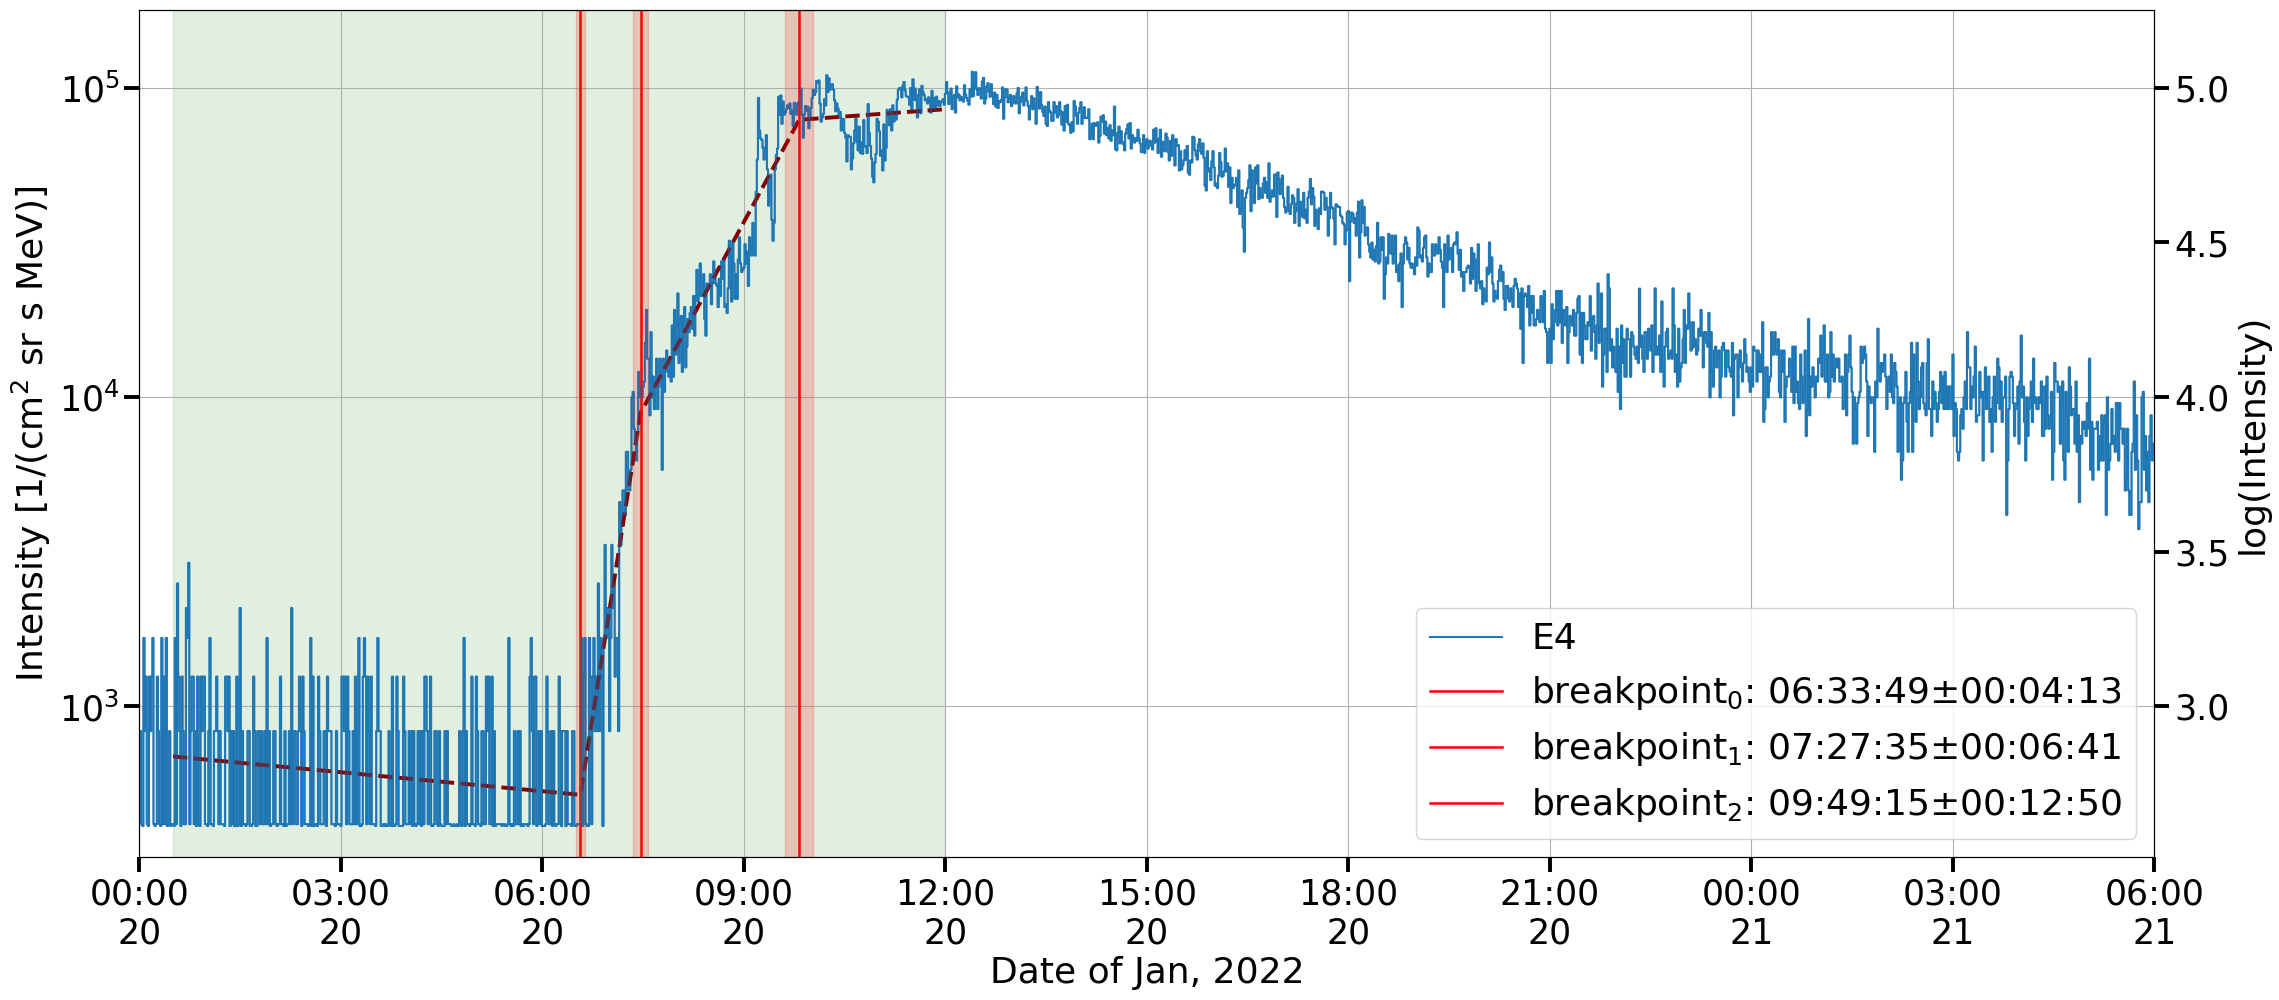

In [ ]:
# The number of breakpoints to seek from the data selection
num_of_breaks = 3

# Fills zero counts with a filler falue f
fill_zeroes = True


# Time-averages the data to given cadence
resample = "1min"

# Boundaries of the time axis
xlim = ["2022-01-20 00:00", "2022-01-21 06:00"]

# Title for the figure (optional)
# SEPpy-data comes with generated titles, so user need not write one themself
title = None # Set own title for user defined file

%matplotlib inline
results = event.find_breakpoints(channel=channel, breaks=num_of_breaks, fill_zeroes=fill_zeroes, 
                                 xlim=xlim, title=title, resample=resample, diagnostics=True)

### 5.1 The Results of the Regression Analysis
#### the results are a dictionary that contains the parameters of the fits (constant and slopes), the breakpoints and their 95% confidence intervals, the figure and its axes.

In [ ]:
display(results)

{'const': np.float64(9318.550362179049),
 'alpha0': np.float64(-5.671188017582659e-06),
 'alpha1': np.float64(0.0003826401506934399),
 'alpha2': np.float64(0.00011154886154063793),
 'alpha3': np.float64(4.3660459737638094e-06),
 'breakpoint0': Timestamp('2022-01-20 06:33:49.824967623'),
 'breakpoint1': Timestamp('2022-01-20 07:27:35.791282654'),
 'breakpoint2': Timestamp('2022-01-20 09:49:15.198572874'),
 'breakpoint0_errors': (Timestamp('2022-01-20 06:29:36.401236296'),
  Timestamp('2022-01-20 06:38:03.248698950')),
 'breakpoint1_errors': (Timestamp('2022-01-20 07:20:54.024017334'),
  Timestamp('2022-01-20 07:34:17.558547974')),
 'breakpoint2_errors': (Timestamp('2022-01-20 09:36:24.832336664'),
  Timestamp('2022-01-20 10:02:05.564809084')),
 'fit_curve': 2022-01-20 00:30:00.000000000    2.838017
 2022-01-20 00:30:41.381381273    2.837782
 2022-01-20 00:31:22.762762785    2.837547
 2022-01-20 00:32:04.144144058    2.837313
 2022-01-20 00:32:45.525525570    2.837078
                   

## 6. Saving the Figure
Running the next cell will save the figure in the local folder with the given name.

In [ ]:
figure_name = "name_for_your_figure.png"

reg.externals.save_figure(results=results, name=figure_name)

## 7. Advanced: Combining Energy Channels
#### (optional, SEPpy only)
> In the next cell the user is able to combine energy channels together and add them to the tool. The new combined channel will be added to the end of the list of channels.

> Channels are combined by giving the indices (inclusive) of the desired channels as a list, e.g., [1,3], which would combine channels 1, 2 and 3 together.

> Disclaimer: Combining Wind/3DP, SOHO/EPHIN and SolO/STEP energy channels is not supported in the current version.

#### Running the next cell has no effect if you don't have SEPpy selected as the data source

In [ ]:
# This is a list of two integer numbers; give the start and end indices of the channels
# that you want to combine together.
# Leaving this to None will have no effect.
channels_to_combine = [1,3]

if select_data._seppy_selected(select_data.data_file):
    event.combine_channels(seppy_data=seppy_data, channels=channels_to_combine)

In [ ]:
# Display the list of channels, and see that the new combined was added to the end of the list
with pd.option_context("display.max_rows", None):
    display(event.meta_df)

None